<a href="https://colab.research.google.com/github/garynico/IndoBERT-Hoax/blob/main/IndoBERT_Hoax_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IndoBERT for Bahasa Indonesia Hoax News Detection

### Import library

In [1]:
# Drive
from google.colab import files
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
source_folder = '/content/drive/MyDrive/TASI/Bayessian/DataImbalance'
destination_folder = '/content/drive/MyDrive/TASI/Bayessian/ModelImbalance'

In [3]:
%cd //content/drive/MyDrive/TASI/GridSearch/DataImbalance

[Errno 2] No such file or directory: '//content/drive/MyDrive/TASI/GridSearch/DataImbalance'
/content


In [4]:
!pip install transformers
!pip install keras.preprocessing
!pip install git+https://github.com/pytorch/text.git@v0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pytorch/text.git (to revision v0.10.0) to /tmp/pip-req-build-7ih82v53
  Running command git clone --filter=blob:none --quiet https://github.com/pytorch/text.git /tmp/pip-req-build-7ih82v53
  Running command git checkout -q 4da1de36247aa06622088e78508e0e38a4392e38
  Resolved h

In [5]:
import pandas as pd
import numpy as np
import torch


from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Preliminaries
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator


# Models
import torch.nn as nn

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

## Preliminaries

In [6]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

##Random Seed

In [8]:
import random

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # jika menggunakan multiple GPUs
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Model

In [9]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('Label', label_field), ('Tokenizing_Head', text_field), ('Tokenizing_Body', text_field)]

train, valid, test = TabularDataset.splits(path=source_folder, train='train3.csv', validation='valid3.csv', test='test3.csv',
                                           format='csv', fields=fields, skip_header=True)


In [10]:
# Iterators
train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.Tokenizing_Body),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.Tokenizing_Body),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

In [11]:
# Module
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "indobenchmark/indobert-base-p1"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    # def forward(self, headline, body, label=None):
    #     loss, text_fea = self.encoder(input_ids=body, attention_mask=(body!=PAD_INDEX), token_type_ids=(headline!=PAD_INDEX), labels=label)[:2]
    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [12]:
def save_checkpoint(save_path, model, valid_loss):
    if save_path is None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model):
    if load_path is None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, epoch_list):
    if save_path is None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'epoch_list': epoch_list}

    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')


def load_metrics(load_path):
    if load_path is None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Metrics loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['epoch_list']

## Training and Validation

In [13]:
def train(model,
          optimizer,
          criterion=nn.BCELoss(),
          train_loader=train_iter,
          valid_loader=valid_iter,
          num_epochs=10,
          eval_every=1,
          file_path=destination_folder,
          best_valid_loss=float("Inf"),
          patience=3):

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    epoch_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text), _ in train_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()

        # evaluation step
        if epoch % eval_every == 0:
            model.eval()
            with torch.no_grad():
                # validation loop
                for (labels, title, text), _ in valid_loader:
                    labels = labels.type(torch.LongTensor)
                    labels = labels.to(device)
                    text = text.type(torch.LongTensor)
                    text = text.to(device)
                    output = model(text, labels)
                    loss, _ = output

                    valid_running_loss += loss.item()

            # evaluation
            average_train_loss = running_loss / len(train_loader)
            average_valid_loss = valid_running_loss / len(valid_loader)
            train_loss_list.append(average_train_loss)
            valid_loss_list.append(average_valid_loss)
            epoch_list.append(epoch)

            # resetting running values
            running_loss = 0.0
            valid_running_loss = 0.0
            model.train()

            # print progress
            print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                  .format(epoch+1, num_epochs, average_train_loss, average_valid_loss))

            # checkpoint
            if best_valid_loss > average_valid_loss:
                best_valid_loss = average_valid_loss
                save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, epoch_list)

    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, epoch_list)
    print('Finished Training!')
    return train_loss_list, valid_loss_list, epoch_list, best_valid_loss

In [14]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train_loss_list, valid_loss_list, epoch_list, best_valid_loss = train(model=model, optimizer=optimizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6521, Valid Loss: 0.7228
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.6210, Valid Loss: 0.6529
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.2738, Valid Loss: 0.2941
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/10], Train Loss: 0.1369, Valid Loss: 0.2067
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [5/10], Train Loss: 0.0909, Valid Loss: 0.1357
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance

Metrics loaded from <== /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt


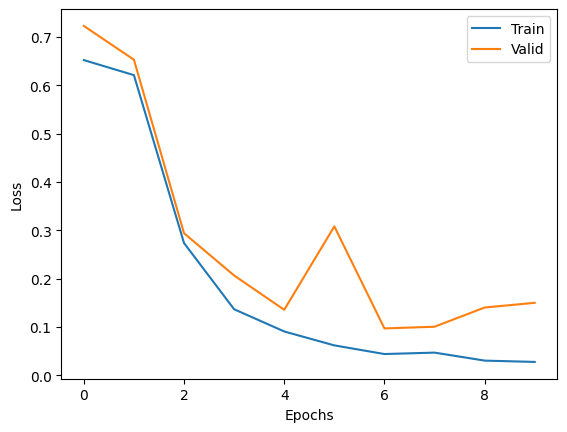

In [15]:
train_loss_list, valid_loss_list, epoch_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(epoch_list, train_loss_list, label='Train')
plt.plot(epoch_list, valid_loss_list, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Classification Report:
Real - Precision: 0.8632, Recall: 0.9266, F1-Score: 0.8938
Fake - Precision: 0.9633, Recall: 0.9292, F1-Score: 0.9459
Accuracy: 0.9283582089552239


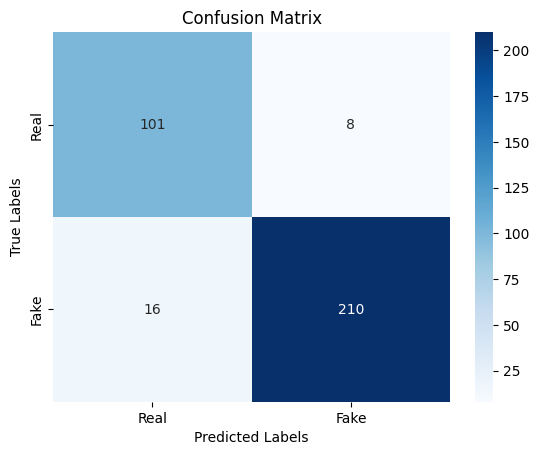

In [16]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text), _ in test_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    # Mengganti label 1 menjadi "real" dan label 0 menjadi "fake"
    y_true = np.where(np.array(y_true) == 1, "real", "fake")
    y_pred = np.where(np.array(y_pred) == 1, "real", "fake")

    # Menghitung dan mencetak hasil precision, recall, f1-score, dan accuracy
    report = classification_report(y_true, y_pred, labels=["real", "fake"], digits=4, output_dict=True)
    print('Classification Report:')
    for label, scores in report.items():
        if label in ["real", "fake"]:
            precision = scores['precision']
            recall = scores['recall']
            f1_score = scores['f1-score']
            print(f"{label.capitalize()} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')

    # Menghitung dan mencetak confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Real', 'Fake'])
    ax.yaxis.set_ticklabels(['Real', 'Fake'])
    plt.show()

best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)

##Hyperparameter Tuning with Import Grid

In [17]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.4 MB/s eta 0:00:00


In [18]:
import optuna

# Define an objective function to optimize hyperparameters
def objective(trial):
    # Sample hyperparameters
    lr = trial.suggest_categorical('lr', [2e-5, 3e-5, 5e-5])
    num_epochs = trial.suggest_categorical('num_epochs', [5, 6, 7, 8, 9, 10])
    batch_size = trial.suggest_categorical('batch_size', [16, 32])

    # Define model, optimizer, and criterion
    model = BERT().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Train model
    train_loss_list, valid_loss_list, epoch_list, best_valid_loss = train(model=model,
                                                                          optimizer=optimizer,
                                                                          criterion=criterion,
                                                                          train_loader=train_iter,
                                                                          valid_loader=valid_iter,
                                                                          num_epochs=num_epochs,
                                                                          eval_every=1,
                                                                          file_path=destination_folder)

    # Save results
    key = f'lr={lr}, num_epochs={num_epochs}, batch_size={batch_size}'
    results[key] = {
        'train_loss': train_loss_list[-1],
        'valid_loss': valid_loss_list,
        'epoch_list': epoch_list,
        'best_valid_loss': best_valid_loss,
        'lr': lr,
        'num_epochs': num_epochs,
        'batch_size': batch_size,
    }

    # Save model if best
    if best_valid_loss < results.get('best_valid_loss', float('inf')):
        results['best_valid_loss'] = best_valid_loss
        results['best_model'] = key
        torch.save(model.state_dict(), f'{destination_folder}/model_{key}.pt')

    return best_valid_loss

# Set up Optuna study with RandomSampler
sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(direction='minimize', sampler=sampler)

# Run optimization
results = {}
study.optimize(objective, n_trials=36)

# Print best model and hyperparameters
best_model = results['best_model']
best_hyperparams = results[best_model]
print('Best model:', best_model)
print('Best valid loss:', best_hyperparams['best_valid_loss'])

[I 2023-06-20 02:37:29,085] A new study created in memory with name: no-name-aa108daa-59bd-47af-b3f0-2246e36e0bfd
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.4816, Valid Loss: 0.3681
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/9], Train Loss: 0.2258, Valid Loss: 0.2334
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/9], Train Loss: 0.1561, Valid Loss: 0.1817
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/9], Train Loss: 0.0758, Valid Loss: 0.1827
Epoch [5/9], Train Loss: 0.0441, Valid Loss: 0.1285
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [6/9], Train Loss: 0.0364, Valid Loss: 0.1357
Epoch [7/9], Train Loss:

[I 2023-06-20 02:40:40,660] Trial 0 finished with value: 0.12848430427922203 and parameters: {'lr': 3e-05, 'num_epochs': 9, 'batch_size': 16}. Best is trial 0 with value: 0.12848430427922203.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6691, Valid Loss: 0.6541
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/8], Train Loss: 0.5685, Valid Loss: 0.4617
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/8], Train Loss: 0.2378, Valid Loss: 0.1763
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/8], Train Loss: 0.1588, Valid Loss: 0.2200
Epoch [5/8], Train Loss: 0.0823, Valid Loss: 0.2721
Epoch [6/8], Train Loss: 0.0448, Valid Loss: 0.1922
Epoch [7/8], Train Loss: 0.0196, Valid Loss: 0.4488


[I 2023-06-20 02:43:21,777] Trial 1 finished with value: 0.17633572087756225 and parameters: {'lr': 2e-05, 'num_epochs': 8, 'batch_size': 16}. Best is trial 0 with value: 0.12848430427922203.


Epoch [8/8], Train Loss: 0.0410, Valid Loss: 0.2003
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.5388, Valid Loss: 0.3162
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/5], Train Loss: 0.2241, Valid Loss: 0.1698
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/5], Train Loss: 0.1364, Valid Loss: 0.1923
Epoch [4/5], Train Loss: 0.0849, Valid Loss: 0.1918


[I 2023-06-20 02:45:02,187] Trial 2 finished with value: 0.16979740713057773 and parameters: {'lr': 5e-05, 'num_epochs': 5, 'batch_size': 16}. Best is trial 0 with value: 0.12848430427922203.


Epoch [5/5], Train Loss: 0.0693, Valid Loss: 0.2180
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6402, Valid Loss: 0.6259
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.4235, Valid Loss: 0.3492
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.2133, Valid Loss: 0.1698
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/7], Train Loss: 0.1501, Valid Loss: 0.2211
Epoch [5/7], Train Loss: 0.0655, Valid Loss: 0.1788
Epoch [6/7], Train Loss: 0.0247, Valid Loss: 0.1918


[I 2023-06-20 02:47:22,324] Trial 3 finished with value: 0.1698474217472332 and parameters: {'lr': 3e-05, 'num_epochs': 7, 'batch_size': 32}. Best is trial 0 with value: 0.12848430427922203.


Epoch [7/7], Train Loss: 0.0260, Valid Loss: 0.3150
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6746, Valid Loss: 0.6524
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/8], Train Loss: 0.6941, Valid Loss: 0.6543
Epoch [3/8], Train Loss: 0.6575, Valid Loss: 0.6070
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/8], Train Loss: 0.5879, Valid Loss: 0.5402
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [5/8], Train Loss: 0.2434, Valid Loss: 0.3466
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [6/8], Train Loss: 0.2152, Valid Loss: 0.2374
Model saved to ==> /cont

[I 2023-06-20 02:50:11,734] Trial 4 finished with value: 0.1984615845472685 and parameters: {'lr': 3e-05, 'num_epochs': 8, 'batch_size': 16}. Best is trial 0 with value: 0.12848430427922203.


Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6620, Valid Loss: 0.6471
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/9], Train Loss: 0.4811, Valid Loss: 0.2750
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/9], Train Loss: 0.1876, Valid Loss: 0.1466
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/9], Train Loss: 0.1245, Valid Loss: 0.1767
Epoch [5/9], Train Loss: 0.0667, Valid Loss: 0.1064
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [6/9], Train Loss: 0.0317, Valid Loss: 0.0924
Model saved to ==> /cont

[I 2023-06-20 02:53:16,810] Trial 5 finished with value: 0.09240064836506333 and parameters: {'lr': 2e-05, 'num_epochs': 9, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.5607, Valid Loss: 0.4028
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/5], Train Loss: 0.3291, Valid Loss: 0.2095
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/5], Train Loss: 0.1855, Valid Loss: 0.2913
Epoch [4/5], Train Loss: 0.1111, Valid Loss: 0.4109
Epoch [5/5], Train Loss: 0.0821, Valid Loss: 0.1976


[I 2023-06-20 02:55:00,617] Trial 6 finished with value: 0.19758616090153477 and parameters: {'lr': 3e-05, 'num_epochs': 5, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Train Loss: 0.6586, Valid Loss: 0.5734
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/5], Train Loss: 0.4001, Valid Loss: 0.3918
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/5], Train Loss: 0.2101, Valid Loss: 0.2801
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/5], Train Loss: 0.1140, Valid Loss: 0.2157
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt


[I 2023-06-20 02:56:45,556] Trial 7 finished with value: 0.21572646798033798 and parameters: {'lr': 3e-05, 'num_epochs': 5, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [5/5], Train Loss: 0.0696, Valid Loss: 0.2536
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6769, Valid Loss: 0.7139
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/8], Train Loss: 0.6750, Valid Loss: 0.7299
Epoch [3/8], Train Loss: 0.6463, Valid Loss: 0.6891
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/8], Train Loss: 0.6312, Valid Loss: 0.6934
Epoch [5/8], Train Loss: 0.6981, Valid Loss: 0.6739
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [6/8], Train Loss: 0.7217, Valid Loss: 0.6874
Epoch [7/8], Train Loss: 0.7630, Valid Loss: 0.6804


[I 2023-06-20 02:59:25,148] Trial 8 finished with value: 0.6738949077469962 and parameters: {'lr': 2e-05, 'num_epochs': 8, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [8/8], Train Loss: 0.6842, Valid Loss: 0.6881
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6352, Valid Loss: 0.7085
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.6265, Valid Loss: 0.3852
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.2581, Valid Loss: 0.2223
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/7], Train Loss: 0.1732, Valid Loss: 0.1799
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [5/7], Train Loss: 0.1392, Valid Loss: 0.2341
Epoch [6/7], Train Loss: 0.0964, Valid Loss: 0.1586
Model saved to ==> /cont

[I 2023-06-20 03:01:49,338] Trial 9 finished with value: 0.15860417817852326 and parameters: {'lr': 5e-05, 'num_epochs': 7, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [7/7], Train Loss: 0.0381, Valid Loss: 0.2332
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6687, Valid Loss: 0.7625
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/9], Train Loss: 0.6624, Valid Loss: 0.6078
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/9], Train Loss: 0.6740, Valid Loss: 0.6717
Epoch [4/9], Train Loss: 0.6419, Valid Loss: 0.7078
Epoch [5/9], Train Loss: 0.3603, Valid Loss: 0.5028
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [6/9], Train Loss: 0.2351, Valid Loss: 0.5078
Epoch [7/9], Train Loss: 0.1461, Valid Loss: 0.4305
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessia

[I 2023-06-20 03:04:55,197] Trial 10 finished with value: 0.3794747510525797 and parameters: {'lr': 2e-05, 'num_epochs': 9, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6542, Valid Loss: 0.6597
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/9], Train Loss: 0.6141, Valid Loss: 0.5685
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/9], Train Loss: 0.3796, Valid Loss: 0.3221
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/9], Train Loss: 0.2050, Valid Loss: 0.2045
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [5/9], Train Loss: 0.1320, Valid Loss: 0.2258
Epoch [6/9], Train Loss: 0.0940, Valid Loss: 0.2124
Epoch [7/9], Train Loss:

[I 2023-06-20 03:07:59,563] Trial 11 finished with value: 0.20445974064724787 and parameters: {'lr': 2e-05, 'num_epochs': 9, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [9/9], Train Loss: 0.0284, Valid Loss: 0.3299
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6506, Valid Loss: 0.6622
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/9], Train Loss: 0.6936, Valid Loss: 0.6631
Epoch [3/9], Train Loss: 0.5582, Valid Loss: 0.8078
Epoch [4/9], Train Loss: 0.2981, Valid Loss: 0.3112
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [5/9], Train Loss: 0.2083, Valid Loss: 0.4980
Epoch [6/9], Train Loss: 0.1487, Valid Loss: 0.3008
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [7/9], Train Loss: 0.1049, Valid Loss: 0.1772
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessia

[I 2023-06-20 03:11:02,955] Trial 12 finished with value: 0.17719441998217786 and parameters: {'lr': 3e-05, 'num_epochs': 9, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [9/9], Train Loss: 0.0151, Valid Loss: 0.2429
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6779, Valid Loss: 0.6803
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.7046, Valid Loss: 0.6311
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.3884, Valid Loss: 0.2675
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/10], Train Loss: 0.2266, Valid Loss: 0.3026
Epoch [5/10], Train Loss: 0.1294, Valid Loss: 0.2443
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [6/10], Train Loss: 0.0964, Valid Loss: 0.2438
Model saved to ==>

[I 2023-06-20 03:14:26,207] Trial 13 finished with value: 0.16910329081916384 and parameters: {'lr': 2e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [10/10], Train Loss: 0.0164, Valid Loss: 0.1758
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6565, Valid Loss: 0.6893
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/6], Train Loss: 0.5636, Valid Loss: 0.3135
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/6], Train Loss: 0.2297, Valid Loss: 0.3200
Epoch [4/6], Train Loss: 0.1937, Valid Loss: 0.5729
Epoch [5/6], Train Loss: 0.1175, Valid Loss: 0.2782
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt


[I 2023-06-20 03:16:27,867] Trial 14 finished with value: 0.27824293426238 and parameters: {'lr': 5e-05, 'num_epochs': 6, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Epoch [6/6], Train Loss: 0.0696, Valid Loss: 0.2938
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6797, Valid Loss: 0.6727
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/9], Train Loss: 0.6919, Valid Loss: 0.7160
Epoch [3/9], Train Loss: 0.6727, Valid Loss: 0.6926
Epoch [4/9], Train Loss: 0.7138, Valid Loss: 0.6601
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [5/9], Train Loss: 0.7058, Valid Loss: 0.6799
Epoch [6/9], Train Loss: 0.6566, Valid Loss: 0.6777
Epoch [7/9], Train Loss: 0.7597, Valid Loss: 0.6908
Epoch [8/9], Train Loss: 0.7172, Valid Loss: 0.6571
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [9/9], Train Loss: 0.6655, Valid Loss: 0.6567


[I 2023-06-20 03:19:28,181] Trial 15 finished with value: 0.6566716070686068 and parameters: {'lr': 3e-05, 'num_epochs': 9, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6816, Valid Loss: 0.6698
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/9], Train Loss: 0.6850, Valid Loss: 0.6978
Epoch [3/9], Train Loss: 0.6730, Valid Loss: 0.6120
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/9], Train Loss: 0.3689, Valid Loss: 0.2510
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [5/9], Train Loss: 0.2111, Valid Loss: 0.2006
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [6/9], Train Loss: 0.1103, Valid Loss: 0.2209
Epoch [7/9], Train Loss:

[I 2023-06-20 03:22:33,459] Trial 16 finished with value: 0.1816657354855644 and parameters: {'lr': 2e-05, 'num_epochs': 9, 'batch_size': 16}. Best is trial 5 with value: 0.09240064836506333.


Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6584, Valid Loss: 0.6465
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.5230, Valid Loss: 0.2937
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.2317, Valid Loss: 0.2287
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/10], Train Loss: 0.1366, Valid Loss: 0.2436
Epoch [5/10], Train Loss: 0.0847, Valid Loss: 0.2354
Epoch [6/10], Train Loss: 0.0338, Valid Loss: 0.0947
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [7/10], Trai

[I 2023-06-20 03:25:54,491] Trial 17 finished with value: 0.09470639319624752 and parameters: {'lr': 3e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [10/10], Train Loss: 0.0075, Valid Loss: 0.1875
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6895, Valid Loss: 0.6702
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.6897, Valid Loss: 0.5277
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.2992, Valid Loss: 0.2106
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/10], Train Loss: 0.1673, Valid Loss: 0.2013
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [5/10], Train Loss: 0.0977, Valid Loss: 0.1957
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance

[I 2023-06-20 03:29:24,507] Trial 18 finished with value: 0.12510732350139214 and parameters: {'lr': 2e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [10/10], Train Loss: 0.0092, Valid Loss: 0.1593
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6031, Valid Loss: 0.4237
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.4236, Valid Loss: 0.2619
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.2116, Valid Loss: 0.2057
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/10], Train Loss: 0.1259, Valid Loss: 0.2350
Epoch [5/10], Train Loss: 0.1063, Valid Loss: 0.2165
Epoch [6/10], Train Loss: 0.0791, Valid Loss: 0.2112
Epoch [7/10], Train Loss: 0.0426, Valid Loss: 0.3720
Epoch [8/10], Train Loss: 0.0601, Valid Loss: 0.3508
Epoch [9/10], Train Loss: 0.0335, Valid Loss: 0.1949
Model saved to ==> /conte

[I 2023-06-20 03:32:44,151] Trial 19 finished with value: 0.1949223618056359 and parameters: {'lr': 5e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [10/10], Train Loss: 0.0087, Valid Loss: 0.1997
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.5904, Valid Loss: 0.5083
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/6], Train Loss: 0.3288, Valid Loss: 0.2278
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/6], Train Loss: 0.1973, Valid Loss: 0.1578
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/6], Train Loss: 0.0960, Valid Loss: 0.1835
Epoch [5/6], Train Loss: 0.0680, Valid Loss: 0.1663
Epoch [6/6], Train Loss: 0.0630, Valid Loss: 0.1268


[I 2023-06-20 03:34:48,468] Trial 20 finished with value: 0.12679849954188935 and parameters: {'lr': 2e-05, 'num_epochs': 6, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6901, Valid Loss: 0.6592
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.7029, Valid Loss: 0.6640
Epoch [3/10], Train Loss: 0.6745, Valid Loss: 0.6240
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/10], Train Loss: 0.5291, Valid Loss: 0.4417
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [5/10], Train Loss: 0.1840, Valid Loss: 0.2206
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [6/10], Train Loss: 0.1507, Valid Loss: 0.1921
Model saved to ==>

[I 2023-06-20 03:38:13,870] Trial 21 finished with value: 0.1559225658087858 and parameters: {'lr': 2e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6938, Valid Loss: 0.6636
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.6757, Valid Loss: 0.6610
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.7040, Valid Loss: 0.6818
Epoch [4/10], Train Loss: 0.5357, Valid Loss: 0.4018
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [5/10], Train Loss: 0.2390, Valid Loss: 0.2424
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [6/10], Train Loss: 0.1609, Valid Loss: 0.2379
Model saved to ==>

[I 2023-06-20 03:41:38,813] Trial 22 finished with value: 0.21149911042968078 and parameters: {'lr': 2e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [10/10], Train Loss: 0.0342, Valid Loss: 0.5232
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6808, Valid Loss: 0.6495
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.6516, Valid Loss: 0.5071
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.3520, Valid Loss: 0.3623
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/10], Train Loss: 0.2007, Valid Loss: 0.2038
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [5/10], Train Loss: 0.1257, Valid Loss: 0.2797
Epoch [6/10], Train Loss: 0.0715, Valid Loss: 0.1328
Model saved to ==>

[I 2023-06-20 03:45:06,790] Trial 23 finished with value: 0.13284434065488832 and parameters: {'lr': 2e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [10/10], Train Loss: 0.0154, Valid Loss: 0.1850
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6780, Valid Loss: 0.6974
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.7101, Valid Loss: 0.6480
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.5625, Valid Loss: 0.4113
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/10], Train Loss: 0.2713, Valid Loss: 0.2721
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [5/10], Train Loss: 0.1427, Valid Loss: 0.2577
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance

[I 2023-06-20 03:48:37,569] Trial 24 finished with value: 0.17279775036565428 and parameters: {'lr': 2e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [10/10], Train Loss: 0.0195, Valid Loss: 0.1856
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6485, Valid Loss: 0.6478
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.4216, Valid Loss: 0.2810
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.2196, Valid Loss: 0.2011
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/10], Train Loss: 0.1943, Valid Loss: 0.2199
Epoch [5/10], Train Loss: 0.0993, Valid Loss: 0.1534
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [6/10], Train Loss: 0.0273, Valid Loss: 0.1941
Epoch [7/10], Trai

[I 2023-06-20 03:51:57,442] Trial 25 finished with value: 0.15339245354490622 and parameters: {'lr': 3e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [10/10], Train Loss: 0.0304, Valid Loss: 0.3363
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6361, Valid Loss: 0.5379
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.3514, Valid Loss: 0.2138
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.1970, Valid Loss: 0.1561
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/10], Train Loss: 0.1212, Valid Loss: 0.1876
Epoch [5/10], Train Loss: 0.0693, Valid Loss: 0.2202
Epoch [6/10], Train Loss: 0.0277, Valid Loss: 0.1702
Epoch [7/10], Train Loss: 0.0151, Valid Loss: 0.1805
Epoch [8/10], Train Loss: 0.0150, Valid Loss: 0.1567
Epoch [9/10], Train Loss: 0.0116, Valid Loss: 0.2096


[I 2023-06-20 03:55:15,995] Trial 26 finished with value: 0.15606455198888267 and parameters: {'lr': 2e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [10/10], Train Loss: 0.0118, Valid Loss: 0.3580
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/6], Train Loss: 0.6910, Valid Loss: 0.6724
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/6], Train Loss: 0.6936, Valid Loss: 0.7108
Epoch [3/6], Train Loss: 0.6981, Valid Loss: 0.6707
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/6], Train Loss: 0.6795, Valid Loss: 0.6952
Epoch [5/6], Train Loss: 0.7310, Valid Loss: 0.7079


[I 2023-06-20 03:57:15,344] Trial 27 finished with value: 0.6707189849444798 and parameters: {'lr': 2e-05, 'num_epochs': 6, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [6/6], Train Loss: 0.6961, Valid Loss: 0.6709
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6680, Valid Loss: 0.6747
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.7132, Valid Loss: 0.5902
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.5636, Valid Loss: 0.2794
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/7], Train Loss: 0.1825, Valid Loss: 0.2036
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [5/7], Train Loss: 0.1150, Valid Loss: 0.1835
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/mode

[I 2023-06-20 03:59:45,447] Trial 28 finished with value: 0.10520102546849687 and parameters: {'lr': 5e-05, 'num_epochs': 7, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [7/7], Train Loss: 0.0125, Valid Loss: 0.6660
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6192, Valid Loss: 0.5902
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.3571, Valid Loss: 0.3633
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.1693, Valid Loss: 0.3813
Epoch [4/7], Train Loss: 0.1152, Valid Loss: 0.5136
Epoch [5/7], Train Loss: 0.1041, Valid Loss: 0.3139
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [6/7], Train Loss: 0.0600, Valid Loss: 0.8405


[I 2023-06-20 04:02:06,024] Trial 29 finished with value: 0.3139130058365741 and parameters: {'lr': 5e-05, 'num_epochs': 7, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [7/7], Train Loss: 0.0607, Valid Loss: 0.4079
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.5594, Valid Loss: 0.5517
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.3676, Valid Loss: 0.2726
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.1833, Valid Loss: 0.2159
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/7], Train Loss: 0.1239, Valid Loss: 0.2991
Epoch [5/7], Train Loss: 0.0714, Valid Loss: 0.1594
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [6/7], Train Loss: 0.0471, Valid Loss: 0.1980


[I 2023-06-20 04:04:27,811] Trial 30 finished with value: 0.15939442081643002 and parameters: {'lr': 5e-05, 'num_epochs': 7, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [7/7], Train Loss: 0.0453, Valid Loss: 0.2357
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6278, Valid Loss: 0.6583
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.6920, Valid Loss: 0.7061
Epoch [3/7], Train Loss: 0.6760, Valid Loss: 0.5566
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/7], Train Loss: 0.4634, Valid Loss: 0.6286
Epoch [5/7], Train Loss: 0.3188, Valid Loss: 0.4564
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [6/7], Train Loss: 0.2763, Valid Loss: 0.3862
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [7/7], Train Loss:

[I 2023-06-20 04:06:54,948] Trial 31 finished with value: 0.28149314863341196 and parameters: {'lr': 5e-05, 'num_epochs': 7, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/7], Train Loss: 0.6471, Valid Loss: 0.6528
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/7], Train Loss: 0.5582, Valid Loss: 0.4014
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/7], Train Loss: 0.2505, Valid Loss: 0.5158
Epoch [4/7], Train Loss: 0.1472, Valid Loss: 0.2239
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [5/7], Train Loss: 0.0496, Valid Loss: 0.1855
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [6/7], Train Loss: 0.0137, Valid Loss: 0.2719


[I 2023-06-20 04:09:19,254] Trial 32 finished with value: 0.18550929901123578 and parameters: {'lr': 5e-05, 'num_epochs': 7, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [7/7], Train Loss: 0.0022, Valid Loss: 0.2955
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/9], Train Loss: 0.6751, Valid Loss: 0.6180
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/9], Train Loss: 0.4831, Valid Loss: 0.5768
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/9], Train Loss: 0.2365, Valid Loss: 0.2671
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/9], Train Loss: 0.1321, Valid Loss: 0.2979
Epoch [5/9], Train Loss: 0.0544, Valid Loss: 0.3618
Epoch [6/9], Train Loss: 0.0420, Valid Loss: 0.2542
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [7/9], Train Loss:

[I 2023-06-20 04:12:20,613] Trial 33 finished with value: 0.20122686736950918 and parameters: {'lr': 3e-05, 'num_epochs': 9, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [9/9], Train Loss: 0.0394, Valid Loss: 0.4996
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Train Loss: 0.6427, Valid Loss: 0.6491
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/10], Train Loss: 0.4941, Valid Loss: 0.3132
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/10], Train Loss: 0.2746, Valid Loss: 0.3378
Epoch [4/10], Train Loss: 0.1514, Valid Loss: 0.3626
Epoch [5/10], Train Loss: 0.0794, Valid Loss: 0.7013
Epoch [6/10], Train Loss: 0.0747, Valid Loss: 0.3240
Epoch [7/10], Train Loss: 0.0364, Valid Loss: 0.4782
Epoch [8/10], Train Loss: 0.0394, Valid Loss: 1.0067
Epoch [9/10], Train Loss: 0.0828, Valid Loss: 0.2530
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [10/10], Train Loss

[I 2023-06-20 04:15:41,580] Trial 34 finished with value: 0.21679870570577414 and parameters: {'lr': 5e-05, 'num_epochs': 10, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/8], Train Loss: 0.6433, Valid Loss: 0.6500
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [2/8], Train Loss: 0.5419, Valid Loss: 0.5710
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [3/8], Train Loss: 0.2636, Valid Loss: 0.2337
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [4/8], Train Loss: 0.1531, Valid Loss: 0.1932
Model saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Epoch [5/8], Train Loss: 0.0862, Valid Loss: 0.2117
Epoch [6/8], Train Loss: 0.0359, Valid Loss: 0.1600
Model saved to ==> /cont

[I 2023-06-20 04:18:28,334] Trial 35 finished with value: 0.14649337846120553 and parameters: {'lr': 3e-05, 'num_epochs': 8, 'batch_size': 32}. Best is trial 5 with value: 0.09240064836506333.


Epoch [8/8], Train Loss: 0.0395, Valid Loss: 0.4049
Metrics saved to ==> /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt
Finished Training!
Best model: lr=2e-05, num_epochs=9, batch_size=32
Best valid loss: 0.20445974064724787


Metrics loaded from <== /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/metrics.pt


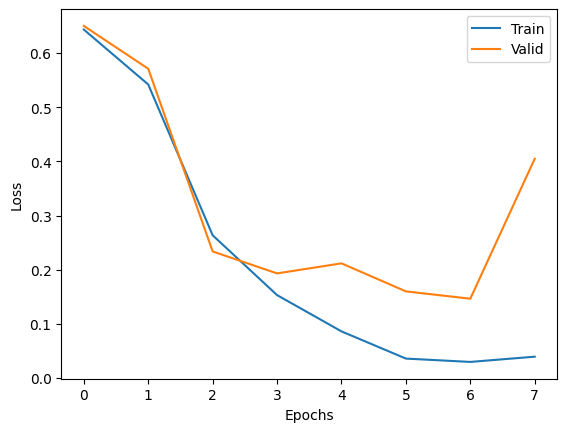

In [19]:
train_loss_list, valid_loss_list, epoch_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(epoch_list, train_loss_list, label='Train')
plt.plot(epoch_list, valid_loss_list, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from <== /content/drive/MyDrive/TASI/Bayessian/ModelImbalance/model.pt
Classification Report:
Real - Precision: 0.8932, Recall: 0.8440, F1-Score: 0.8679
Fake - Precision: 0.9267, Recall: 0.9513, F1-Score: 0.9389
Accuracy: 0.9164179104477612


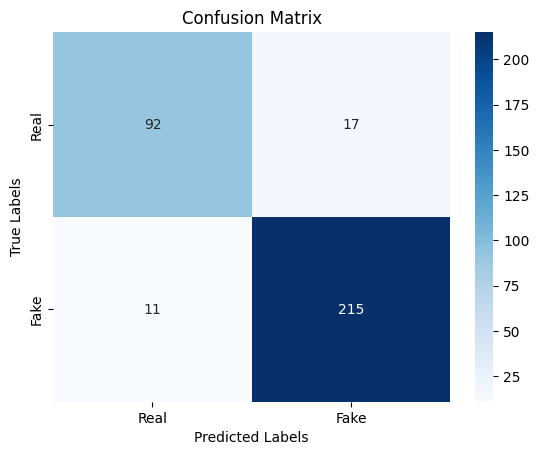

In [20]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text), _ in test_loader:
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            text = text.type(torch.LongTensor)
            text = text.to(device)
            output = model(text, labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    # Mengganti label 1 menjadi "real" dan label 0 menjadi "fake"
    y_true = np.where(np.array(y_true) == 1, "real", "fake")
    y_pred = np.where(np.array(y_pred) == 1, "real", "fake")

    # Menghitung dan mencetak hasil precision, recall, f1-score, dan accuracy
    report = classification_report(y_true, y_pred, labels=["real", "fake"], digits=4, output_dict=True)
    print('Classification Report:')
    for label, scores in report.items():
        if label in ["real", "fake"]:
            precision = scores['precision']
            recall = scores['recall']
            f1_score = scores['f1-score']
            print(f"{label.capitalize()} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy}')

    # Menghitung dan mencetak confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Real', 'Fake'])
    ax.yaxis.set_ticklabels(['Real', 'Fake'])
    plt.show()

best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)